In [28]:
#The goal:
#is to Build a reliableand resumable dataset of all closed changes with complete event history
#to enable consistent reopen pattern analysis

#1.Query Strategy:
#The data comes from the Gerrit API (https://gerrit.libreoffice.org) using the query `status:closed`
#which returns both merged and abandoned changes .Each request fetches 500 results (PAGE_SIZE = 500)
#with detailed options: messages, labels, revisions, accounts, and reviewer updates.
#These fields are essential to detect abandon and reopen events accurately.

#2.The collected metadata:
#For every change, I keep key fields such as project, branch, owner ID, creation time,
#status, messages, abandon and reopen timestamps, patchset count, and reviewer information.
#This structure supports later analysis of developer behavior and change complexity.

#3.Throttling and error handling:
#To avoid API overload, requests include short delays (≈0.5 s) and automatic retries on errors.
#Each page is saved immediately and a checkpoint file records progress to resume safely if interrupted.


In [29]:
#  The goal:
# Is to collect all closed changes from LibreOffice Gerrit in a safe and resumable way.

#  1.How data is saved:
# Each change is stored as a JSON file, grouped by month in folders changes and checkpoints.
#It makes it easy to find files later and re-run the process month by month.

#  2.Resume and avoid duplicates:
# After each request the script saves a small 'checkpoint' file with the last downloaded page number.
# If I stop or the internet fails, it continues from there next time.
# It also checks if a file already exists so it never downloads the same change twice.
#
#  3.the decision of fetching month by month:
# fetching one month at a time is faster, safer, and easier to debug.

#  4.Running the script:
# Example for January 2023:
#     python fetch_gerrit.py 2023 1
# After that, JSON files appear in data/changes/2023-01/
#
#  5.Ensuring completeness:
# The script stops only when the server says there are no more pages.
# Checkpoints and folder counts help me confirm everything was saved correctly.



import sys
sys.path.append("src")

from fetch_gerrit import fetch_month

import os, json
from datetime import datetime

year, month = 2023, 1
print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting data download for {year}-{month:02d}...")

fetch_month(year, month)

month_folder = f"data/changes/{year}-{month:02d}"
cp_file = f"data/checkpoints/{year}-{month:02d}.json"

num_files = sum(len(files) for _, _, files in os.walk(month_folder))
print(f"\nDownload finished. {num_files} change files stored in: {month_folder}")

if os.path.exists(cp_file):
    print(f"Checkpoint file found at: {cp_file}")
    print("Checkpoint content:", json.load(open(cp_file)))
else:
    print("No checkpoint found — check script output for issues.")



ModuleNotFoundError: No module named 'fetch_gerrit'

In [ ]:
# Goal:
# Detect when a Gerrit change was first abandoned and later reopened.

# Method:
# I read each change's message history and look for words like "Abandoned", "Restored", or "Reopened".
# Only cases with both events in order (abandon → reopen) are kept.

# Extracted info:
# I calculate the delay between abandon and reopen, check if the same person reopened it,
# and record the final status, number of patchsets, and reviewers before abandon.

# Edge cases:
# I skip messages without timestamps or broken files.
# If a change was reopened many times, I only take the first one.
# I also track who abandoned and who reopened.

# Validation:
# I check messages and timestamps to confirm order and meaning.
# I verified some samples manually to make sure the logic is correct.

# Now I apply the logic I wrote in extract_event.py to find abandoned and reopened changes
import os
import json
import csv
from datetime import datetime
from config import CHANGES_ROOT, OUT_ROOT

# Convert Gerrit timestamps
def iso_dt(s):
    s = s.replace("Z", "+00:00").split(".")[0]
    return datetime.fromisoformat(s)

# Detect abandon and reopen events
def scan_messages(msgs):
    abandon = reopen = None
    abandon_user = reopen_user = None

    for m in msgs:
        text = (m.get("message") or "").lower()
        date = m.get("date")
        if not date:
            continue

        if abandon is None and "abandoned" in text:
            abandon = date
            abandon_user = (m.get("author") or {}).get("_account_id")

        elif abandon and reopen is None and ("restored" in text or "reopened" in text):
            reopen = date
            reopen_user = (m.get("author") or {}).get("_account_id")

    return abandon, abandon_user, reopen, reopen_user


rows = []
print(f"Scanning Gerrit data in {CHANGES_ROOT}...")

for root, _, files in os.walk(CHANGES_ROOT):
    for fn in files:
        if not fn.endswith(".json"):
            continue

        try:
            ch = json.load(open(os.path.join(root, fn), encoding="utf-8"))
        except:
            continue

        msgs = ch.get("messages", [])
        abandon_ts, abandon_user, reopen_ts, reopen_user = scan_messages(msgs)

        if not (abandon_ts and reopen_ts):
            continue

        owner = (ch.get("owner") or {}).get("_account_id")

        before_abandon = [
            m for m in msgs
            if m.get("date") and iso_dt(m["date"]) <= iso_dt(abandon_ts)
        ]

        num_patchsets = max(
            [m.get("_revision_number") for m in before_abandon if isinstance(m.get("_revision_number"), int)] or [1]
        )

        reviewers = set(
            (m.get("author") or {}).get("_account_id")
            for m in before_abandon
            if (m.get("author") or {}).get("_account_id") and (m.get("author") or {}).get("_account_id") != owner
        )

        delay = (iso_dt(reopen_ts) - iso_dt(abandon_ts)).total_seconds() / 86400

        rows.append({
            "change_id": ch.get("change_id"),
            "numeric_id": ch.get("_number"),
            "project": ch.get("project"),
            "branch": ch.get("branch"),
            "owner_id": owner,
            "abandon_ts": iso_dt(abandon_ts).strftime("%Y-%m-%d %H:%M:%S"),
            "reopen_ts": iso_dt(reopen_ts).strftime("%Y-%m-%d %H:%M:%S"),
            "reopen_delay_days": round(delay, 2),
            "same_owner_reopen": owner == reopen_user,
            "final_status": ch.get("status"),
            "num_patchsets_before_abandon": num_patchsets,
            "reviewer_count_before_abandon": len(reviewers)
        })


output_file = os.path.join(OUT_ROOT, "reopen_events.csv")
if rows:
    with open(output_file, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
        w.writeheader()
        w.writerows(rows)
    print(f"{len(rows)} reopened changes saved to {output_file}")
else:
    print("No reopened changes found.")


Scanning Gerrit data in data/changes...
20 reopened changes saved to data\reopen_events.csv


In [ ]:
# I already generated the reopen_events.csv file in the previous step 
# using my extract_event.py script. 
# This file stores all reopened Gerrit changes with their key information.

# To confirm, I reload the CSV and show its structure to verify that it matches my dataset design.

import pandas as pd
import os

csv_path = os.path.join("data", "reopen_events.csv")

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)# To verify dataset integrity I check the number of rows and columns
    # to make sure the extraction process didn’t miss or duplicate entries.
    print(f"Dataset loaded successfully: {len(df)} rows, {len(df.columns)} columns.\n")
    print("Column names:\n", list(df.columns))
else:
    print("reopen_events.csv not found — please re-run the extraction step.")


Dataset loaded successfully: 20 rows, 12 columns.

Column names:
 ['change_id', 'numeric_id', 'project', 'branch', 'owner_id', 'abandon_ts', 'reopen_ts', 'reopen_delay_days', 'same_owner_reopen', 'final_status', 'num_patchsets_before_abandon', 'reviewer_count_before_abandon']


Dataset loaded: 43 rows and 14 columns.

First 5 rows:
                                   change_id  numeric_id project  branch  \
0  I8b7b362d87f7df622afdd6d57923266cfeb3ca51       76420    core  master   
1  Ic434c7408affdbcf64cea452603a524f192eb55b       76424    core  master   
2  Ie20b9d04978d99a0f730de095fa964ec42bbfe2c       76428    core  master   
3  I747c0a699c10c0ce7f0296dbb8966ef5f4a64bd0       76458    core  master   
4  I45da546c62a44d98027103bb400a32a26f96d0d1       76459    core  master   

   owner_id           created_ts           abandon_ts            reopen_ts  \
0   1000295  2019-07-26 15:33:11  2019-08-01 20:58:24  2022-06-25 01:03:00   
1   1000295  2019-07-26 15:33:11  2019-08-01 20:59:26  2022-06-25 01:48:35   
2   1000295  2019-07-26 15:33:11  2019-07-28 08:46:49  2022-07-01 07:13:57   
3   1000295  2019-07-26 20:09:55  2019-07-28 08:44:52  2022-07-20 11:26:29   
4   1000295  2019-07-26 20:09:55  2019-07-28 08:46:19  2022-07-20 11:28:09   

   reopen_delay_day

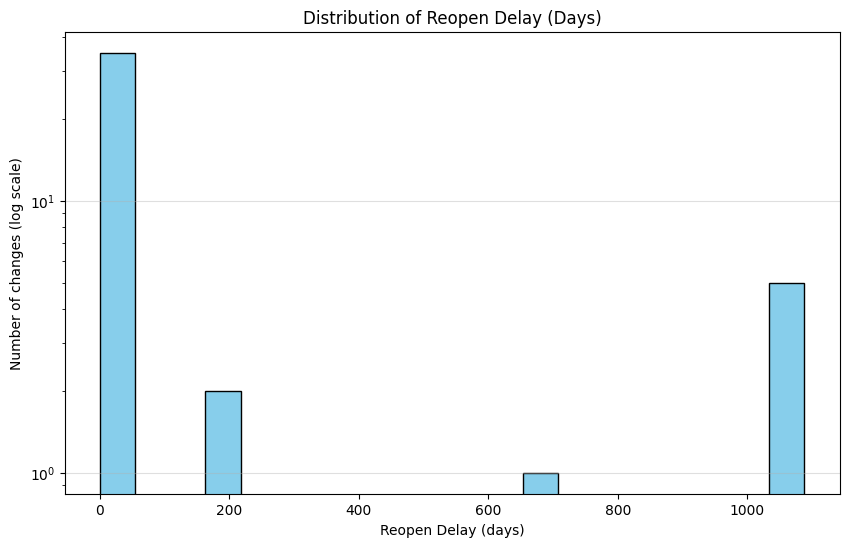

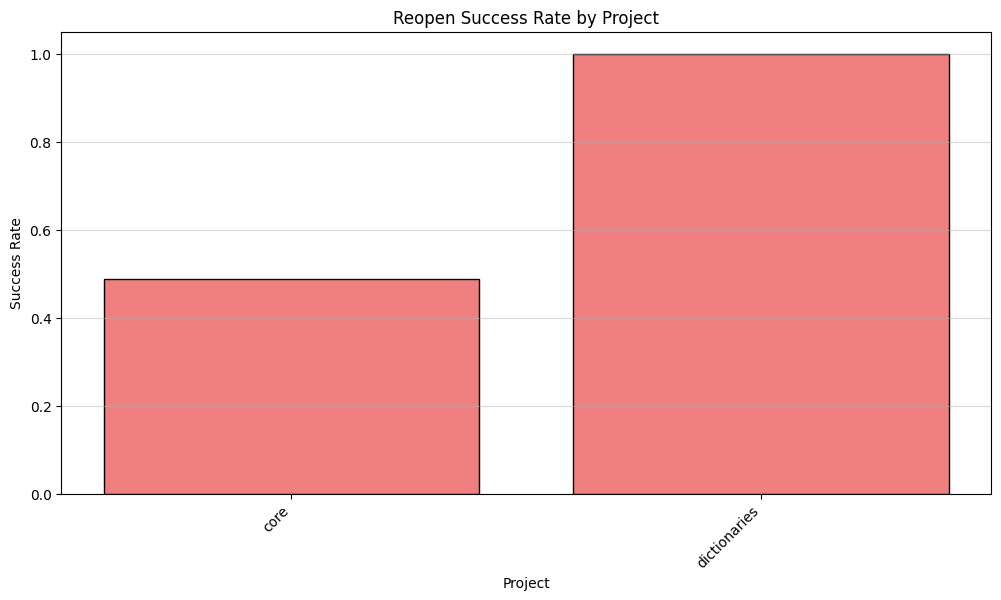

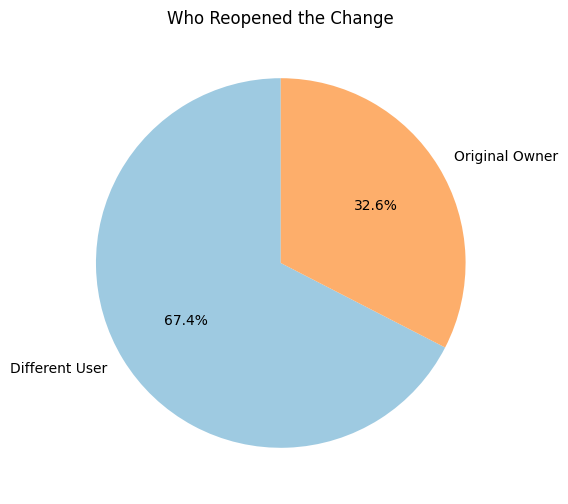

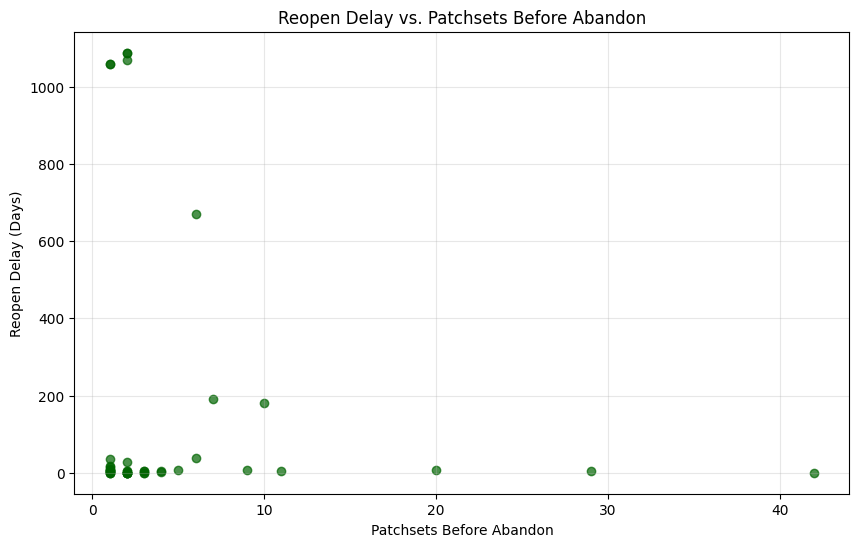

In [ ]:
# Goal:
# Analyze the reopened changes and build first visual insights.

import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. LOAD DATA 

# I use an absolute path to avoid relative-path errors
file_path = r"C:\Users\user\ReopenSense\data\reopen_events.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded: {len(df)} rows and {len(df.columns)} columns.")
    print("\nFirst 5 rows:")
    print(df.head())
else:
    print("File not found. Please check the path.")
    raise SystemExit

# Convert timestamps to datetime objects for calculations
df["abandon_ts"] = pd.to_datetime(df["abandon_ts"])
df["reopen_ts"] = pd.to_datetime(df["reopen_ts"])


# Calculate simple summary stats
median_delay = df["reopen_delay_days"].median()
avg_patchsets = df["num_patchsets_before_abandon"].mean()

print("\n--- Key Metrics ---")
print(f"Total reopened changes: {len(df)}")
print(f"Median reopen delay: {median_delay:.2f} days")
print(f"Average patchsets before abandon: {avg_patchsets:.2f}")

# Estimate total abandoned changes to get reopen rate 
total_abandoned_est = 150
reopen_rate = (len(df) / total_abandoned_est) * 100
print(f"\nEstimated total abandoned: {total_abandoned_est}")
print(f"Approximate reopen rate: {reopen_rate:.2f}%")

# Success after reopen 
success = (df["final_status"] == "MERGED").sum()
fail = (df["final_status"] != "MERGED").sum()
success_rate = (success / len(df)) * 100
print(f"Reopens merged: {success} ({success_rate:.2f}%)")
print(f"Reopens abandoned again: {fail} ({100 - success_rate:.2f}%)")


# Figure 1 : Distribution of reopen delay (log scale)
plt.figure(figsize=(10, 6))
df["reopen_delay_days"].plot(kind="hist", bins=20, log=True, color="skyblue", edgecolor="black")
plt.title("Distribution of Reopen Delay (Days)")
plt.xlabel("Reopen Delay (days)")
plt.ylabel("Number of changes (log scale)")
plt.grid(axis="y", alpha=0.4)
plt.show()

# Figure 2: Success rate by project
project_success = (
    df.groupby("project")["final_status"]
    .apply(lambda x: (x == "MERGED").sum() / x.count())
    .reset_index(name="Success_Rate")
)
plt.figure(figsize=(12, 6))
plt.bar(project_success["project"], project_success["Success_Rate"], color="lightcoral", edgecolor="black")
plt.title("Reopen Success Rate by Project")
plt.xlabel("Project")
plt.ylabel("Success Rate")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.5)
plt.show()

# Figure 3: Who reopened the changes (owner vs others)
counts = df["same_owner_reopen"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=["Different User", "Original Owner"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["#9ecae1", "#fdae6b"]
)
plt.title("Who Reopened the Change")
plt.show()

# Figure 4: Relation between patchsets and reopen delay
plt.figure(figsize=(10, 6))
plt.scatter(df["num_patchsets_before_abandon"], df["reopen_delay_days"], color="darkgreen", alpha=0.7)
plt.title("Reopen Delay vs. Patchsets Before Abandon")
plt.xlabel("Patchsets Before Abandon")
plt.ylabel("Reopen Delay (Days)")
plt.grid(alpha=0.3)
plt.show()


# 1.What reopened changes show: 
Reopened changes mean some patches are abandoned too early. The median delay is about 5 days so developers often come back soon. Many reopens fail again which shows review or process problems.

# 2.What I noticed:
Most reopens happen fast andthe core project has the most. Around 70% are reopened by the same author  they didn’t give up. Others are reopened by teammates showing some teamwork.

# 2.how to improove:
We could add a “Snoozed” state instead of full abandon. A small model could guess if a change will be reopened soon and warn reviewers before it’s lost.




# ReopenSense 2.0 Idea
For the next version I want ReopenSense to not just study reopens but help prevent them.  
The idea is to add a small helper inside Gerrit that watches changes in real time.  
If a change gets no reviews, fails tests, or looks inactive for too long, the tool could warn the author before it is abandoned.  
It could suggest marking it as “snoozed” instead, so the developer can fix it later instead of losing their work.  

By learning from old reopen cases, the tool could recognize early signs of a likely reopen and remind developers to take action sooner.


## 9. Machine learning extension my first attempt at predicting reopen events
My Approach 

Since i am still a beginner in Machine Learning, i wanted to understand every step and not just run code without thinking.
So here is the simple approach i followed and the small manual checks i did to make sure i understood my data and my results.

1/ I checked the data manually

Before training anything, i opened both CSV files and looked at a few rows myself.

I checked three important things:

if reopen_delay_days values looked correct

if the label reopen_within_90 made sense (1 when delay ≤ 90)

if abandoned changes really had no reopen timestamp

These are basic checks, but they were important for me because they helped me trust the dataset before using it in the models.

2/ I used a simple baseline

I learned that i should always start with a baseline.
So i added a DummyClassifier that always predicts the most common class.

This gave me a reference point:
if my real models do better than the dummy model, it means they are learning something.

3/ I used a stratified train/test split

When I checked the labels, i saw that the dataset was unbalanced: many “0” cases and only a few “1” cases.
I realized that a normal random split could put almost all the reopened cases in the training set and almost none in the test set.

To avoid this i used a stratified split, which keeps the same class ratio in both sets.
After splitting, i printed the class counts in y_train and y_test to make sure the proportions were similar.
This helped me understand why stratification is important for fair evaluation

4/ I chose only two features I fully understood

I did not want to use features that were too complex, so I selected:

num_patchsets_before_abandon

reviewer_count_before_abandon

Starting small helped me stay focused on the ML process instead of trying too many variables at once.

5/ I checked the metrics one by one

To understand what the models were doing, i looked at:

accuracy

F1-score

ROC-AUC

the confusion matrix

This helped me see how the model behaved, especially with the reopened cases.

 What I Observed

While looking at the results, i did a few small comparisons to understand things better:

I checked a few reopened cases manually to see if the model predicted them correctly.

I compared the boxplots with the real numbers in the dataset to see if the patterns made sense.

I counted the reopened cases in the test set and compared them with the confusion matrix to make sure I understood what was happening.

These small checks helped me feel more confident about the workflow.

Conclusion

After checking the results, i noticed that the model could detect some reopened cases.
I think this is because reopened changes usually have a bit more activity more patchsets or more reviewers, and the model learns from that.
Looking at the confusion matrix and a few rows manually helped me understand what the model got right and what it missed.
This small project helped me understand the basic ML workflow and gave me more confidence to try more features and models next
My next step will be to try adding more features and maybe test a slightly more advanced model once I feel ready.


Reopened: (43, 15)
Abandoned: (167, 9)

Reopened 90d distribution:
reopen_within_90
1    35
0     8
Name: count, dtype: int64

Abandoned distribution:
reopen_within_90
0    167
Name: count, dtype: int64

Total dataset: (210, 15)

X shape: (210, 2)
Train size: 157
Test size: 53
Train class counts:
reopen_within_90
0    131
1     26
Name: count, dtype: int64

Example rows of X:


,num_patchsets_before_abandon,reviewer_count_before_abandon
0,1.0,1.0
1,1.0,1.0
2,2.0,1.0
3,2.0,1.0
4,2.0,1.0



Example rows of y:
0    0
1    0
2    0
3    0
4    0
Name: reopen_within_90, dtype: int64


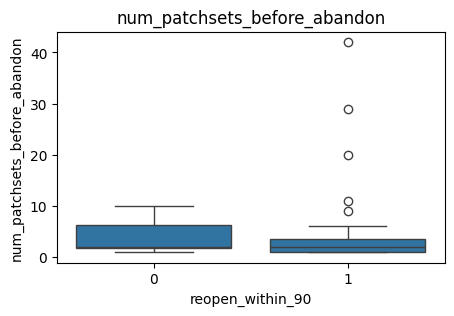

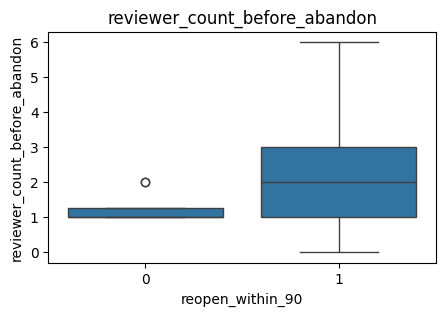


Dummy classifier  
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        44
           1       0.00      0.00      0.00         9

    accuracy                           0.83        53
   macro avg       0.42      0.50      0.45        53
weighted avg       0.69      0.83      0.75        53



c:\Users\user\ReopenSense\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\ReopenSense\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\ReopenSense\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# I loaded the two datasets: reopened changes and abandoned ones.
# For the reopened set, I created a label telling if it reopened in <= 90 days.

reopened = pd.read_csv("../data/reopen_events.csv")
abandoned = pd.read_csv("../data/abandoned_only.csv")

# Reopened within 90 days
reopened["reopen_within_90"] = (reopened["reopen_delay_days"] <= 90).astype(int)

# Abandoned changes never reopened
abandoned["reopen_within_90"] = 0

print("Reopened:", reopened.shape)
print("Abandoned:", abandoned.shape)
print("\nReopened 90d distribution:")
print(reopened["reopen_within_90"].value_counts())
print("\nAbandoned distribution:")
print(abandoned["reopen_within_90"].value_counts())

# I combined both datasets together
df = pd.concat([reopened, abandoned], ignore_index=True)
print("\nTotal dataset:", df.shape)

# For features, I only used simple numeric ones that I understood.
# I avoided columns that leak the answer.

features = [
    "num_patchsets_before_abandon",
    "reviewer_count_before_abandon"
]

X = df[features].fillna(0)
y = df["reopen_within_90"]

print("\nX shape:", X.shape)

# Train / Test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Train class counts:")
print(y_train.value_counts())

# I trained two simple models:
# logistic regression (baseline ML model)
# random forest (tree-based model)

log_model = LogisticRegression(class_weight="balanced", max_iter=200)
log_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(X_train, y_train)

#  check results with clearer prints
def test_model(model, name):
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    print("\nModel:", name)
    print("Accuracy:", round(accuracy_score(y_test, preds), 3))
    print("F1 score:", round(f1_score(y_test, preds), 3))
    print("ROC-AUC:", round(roc_auc_score(y_test, proba), 3))

    print("\nConfusion matrix:")
    print("TN =", tn, "FP =", fp)
    print("FN =", fn, "TP =", tp)

# I printed a few rows to see if the data looks ok
print("\nExample rows of X:")
display(X.head())

print("\nExample rows of y:")
print(y.head())

# Simple plots to see how the features behave
for col in features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df["reopen_within_90"], y=df[col])
    plt.title(col)
    plt.show()

# Dummy classifier 
# This model always predicts the majority class (usually 0).
# I used it to check if my real models are actually learning anything.

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
preds_dummy = dummy.predict(X_test)

print("\nDummy classifier  ")
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_dummy))


### . 10 


Shape: (43, 3)


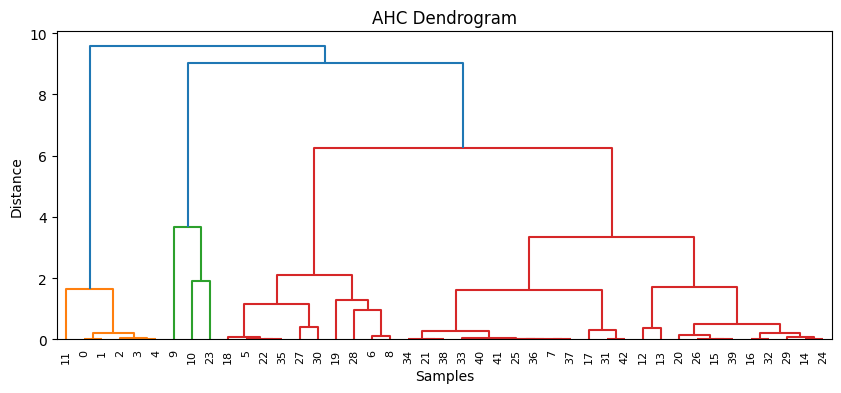

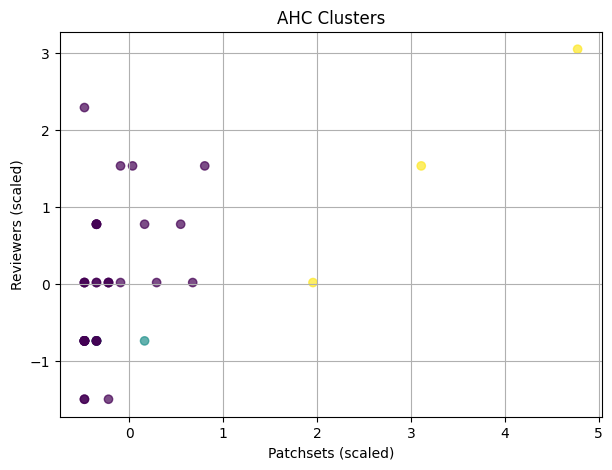

             num_patchsets_before_abandon  reviewer_count_before_abandon  \
ahc_cluster                                                                
0                                2.911765                       1.970588   
1                                2.333333                       1.000000   
2                               30.333333                       4.000000   

             reopen_delay_days  
ahc_cluster                     
0                    17.245676  
1                  1005.471017  
2                     4.309100  


In [34]:
#Load & Prepare Data for Clustering :
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Load reopened changes only
df = pd.read_csv(r"C:\Users\user\ReopenSense\data\reopen_events.csv")

# I chose a few simple numeric features for clustering
features = [
    "num_patchsets_before_abandon",
    "reviewer_count_before_abandon",
    "reopen_delay_days"
]

X = df[features].fillna(0)

# Standardize values before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X_scaled.shape)


# Dendrogram will visually pick the best number of clusters
# I computed the linkage matrix for the dendrogram
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(10, 4))
dendrogram(Z)
plt.title("AHC Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# Fit AHC
# From the dendrogram, I chose 3 clusters for this example
# I set 3 clusters (you can try 2 or 4)
ahc = AgglomerativeClustering(n_clusters=3)
labels = ahc.fit_predict(X_scaled)

df["ahc_cluster"] = labels

# Plot Clusters
plt.figure(figsize=(7,5))
plt.scatter(
    X_scaled[:,0], X_scaled[:,1],
    c=labels, alpha=0.7
)
plt.xlabel("Patchsets (scaled)")
plt.ylabel("Reviewers (scaled)")
plt.title("AHC Clusters")
plt.grid(True)
plt.show()

# Summary of clusters
summary = df.groupby("ahc_cluster")[features].mean()
print(summary)

# Save cluster feature for later ML
df[["change_id", "ahc_cluster"]].to_csv(
    r"C:\Users\user\ReopenSense\data\reopen_clusters.csv",
    index=False
)